<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [8]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
data = pd.read_csv('../data/5.csv')
data

,a,b,values,c,d
0,0,2018-07-25 00:00:00,92408,26971036,177711644
1,0,2018-07-25 00:01:00,92150,26948190,220370286
2,0,2018-07-25 00:02:00,94896,26238222,188035073
3,0,2018-07-25 00:03:00,92694,26087970,191997884
4,0,2018-07-25 00:04:00,93674,25314568,169497214
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521,23637112,138239574
38876,0,2018-08-20 23:56:00,83092,24617816,164460450
38877,0,2018-08-20 23:57:00,84873,25101336,173568370
38878,0,2018-08-20 23:58:00,81736,24181689,157334718


In [10]:
data.drop(columns=['a','b','c','d'],inplace=True)
data

,values
0,92408
1,92150
2,94896
3,92694
4,93674
...,...
38875,81521
38876,83092
38877,84873
38878,81736


In [11]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-NLinear')

['/hdd_1/sjlee/Model_Implementation/online-learning-NLinear']

In [43]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['online-learning-NLinear']['seq_len'])
        self.pred_len = int(configs['online-learning-NLinear']['pred_len'])
        self.channels = int(configs['online-learning-NLinear']['enc_in'])
        self.individual = configs['online-learning-NLinear']['individual']
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        # https://bo-10000.tistory.com/181
        x = (x-seq_last).cpu()
        seq_last = seq_last.cpu()
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [44]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [45]:
sequence_length = 1440
pred_len = 1
split= 1440
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [46]:
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
device = torch.device("cuda:0")

In [47]:
x_seq

tensor([[[ 92408.,  92150.,  94896.,  ...,  98364.,  96225.,  98629.]],

        [[ 92150.,  94896.,  92694.,  ...,  96225.,  98629.,  98278.]],

        [[ 94896.,  92694.,  93674.,  ...,  98629.,  98278.,  97686.]],

        ...,

        [[ 98462., 100969.,  97377.,  ...,  72424.,  72901.,  72965.]],

        [[100969.,  97377.,  94479.,  ...,  72901.,  72965.,  72281.]],

        [[ 97377.,  94479.,  94558.,  ...,  72965.,  72281.,  70918.]]],
       device='cuda:0')

In [48]:
target.size()

torch.Size([36000, 1, 1])

In [49]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq.permute(0,2,1)).to(device)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 12.686371644131011 %
smape 12.375994978431198 %
smape 11.71853858679533 %
smape 10.25151516728931 %
smape 9.853317518780628 %
smape 11.307088601961732 %
smape 10.788437521374888 %
smape 10.40505081878768 %
smape 10.466718790762956 %
smape 10.165046859367026 %
smape 10.175760582875874 %
smape 9.108607832135426 %
smape 9.56797662095891 %
smape 9.430728969557418 %
smape 9.47149806374477 %
smape 10.304998713276452 %
smape 10.557633143415053 %
smape 9.766663519458637 %
smape 10.32466456376844 %
smape 8.904833482702573 %
smape 10.207638292304344 %
smape 7.9408777571800675 %
smape 8.447972863912582 %
smape 9.429371028476291 %
smape 9.292271115589473 %
smape 9.32947107491394 %
smape 9.747935515186853 %
smape 9.893347514793277 %
smape 8.879596909011404 %
smape 8.968632067036298 %
smape 8.998763888246483 %
smape 9.92828369844291 %
smape 10.382810183241965 %
smape 8.822131790800226 %
smape 9.480988712691598 %
smape 6.554846219966809 %
smape 8.807138660467333 %
smape 8.016248546706306 %
smap

In [50]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    for epochs in range(num_epochs):
        if idx == 0:
             new_train = torch.FloatTensor(
            [X.iloc[-sequence_length:].values]
        ).view(1,sequence_length,1).to(device)
                
        else:
            new_train = torch.FloatTensor(
                [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,sequence_length,1).to(device)

        out = model(new_train).to(device) # 예측완료
        
        tg = FloatTensor(target.iloc[idx]).view(1,1,1).to(device)
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(out.cpu().view(1).item())
    time_list.append(end-start)

SMAPE 0.21005112510920299 %
SMAPE 0.525702177866151 %
SMAPE 0.8244375941212639 %
SMAPE 0.40176875438919524 %
SMAPE 0.4679176150530111 %
SMAPE 0.44184053412936913 %
SMAPE 0.31309449435502756 %
SMAPE 0.7168813544303703 %
SMAPE 0.370239963507629 %
SMAPE 0.5442931642683106 %
SMAPE 0.2760919489664957 %
SMAPE 0.4135655613981726 %
SMAPE 1.0703542603587266 %
SMAPE 0.39968918453814695 %
SMAPE 0.702209510425746 %
SMAPE 0.37129413386901433 %
SMAPE 0.5310963655106207 %
SMAPE 0.5188655097554147 %
SMAPE 0.4861350468418095 %
SMAPE 0.562319119075255 %
SMAPE 0.648342489337665 %
SMAPE 0.7275634458637796 %
SMAPE 1.0164541847625514 %
SMAPE 0.536691473913379 %
SMAPE 1.1300690677790044 %
SMAPE 0.7276262776895237 %
SMAPE 0.337260923039139 %
SMAPE 0.45058607070677686 %
SMAPE 1.088820905009925 %
SMAPE 0.6321668651653454 %
SMAPE 0.9501840726625234 %
SMAPE 1.3534653600399906 %
SMAPE 1.347143308748855 %
SMAPE 0.5764900792964909 %
SMAPE 1.1591206469311146 %
SMAPE 1.4372096678234811 %
SMAPE 0.5148966684064362 %
SMA

SMAPE 1.2284609425078088 %
SMAPE 0.5598111942781543 %
SMAPE 0.677195446773112 %
SMAPE 0.4713603812851943 %
SMAPE 0.8381106541455664 %
SMAPE 0.5390790491874213 %
SMAPE 0.6142675992159639 %
SMAPE 1.0555222816255991 %
SMAPE 0.5367683045042213 %
SMAPE 1.1926459063543007 %
SMAPE 0.585535406578856 %
SMAPE 0.5175590158760315 %
SMAPE 0.5336604858930514 %
SMAPE 0.5797167222481221 %
SMAPE 1.704937249814975 %
SMAPE 0.8801472674040269 %
SMAPE 0.7371802796405973 %
SMAPE 0.4521197421272518 %
SMAPE 0.5233079335594084 %
SMAPE 0.937100937444484 %
SMAPE 0.589711170825467 %
SMAPE 0.5899038480538366 %
SMAPE 0.29778205072966557 %
SMAPE 0.4611320790863829 %
SMAPE 0.8389594901173041 %
SMAPE 0.6508975708129583 %
SMAPE 0.3895033111475641 %
SMAPE 1.1261628518332145 %
SMAPE 0.3977449239255293 %
SMAPE 0.3443421914234932 %
SMAPE 0.7461607033765176 %
SMAPE 0.37418488185358 %
SMAPE 0.6031349291406514 %
SMAPE 0.34861745451780735 %
SMAPE 1.2270655616812292 %
SMAPE 0.7636269471258856 %
SMAPE 0.47134032602480147 %
SMAPE

SMAPE 0.27187274968400743 %
SMAPE 0.12771113081544172 %
SMAPE 0.06908996940819634 %
SMAPE 0.08728843634412442 %
SMAPE 0.29372954786413175 %
SMAPE 0.0850585359858087 %
SMAPE 0.11530939655312977 %
SMAPE 0.21921211206063163 %
SMAPE 0.33333536389341134 %
SMAPE 0.16673923348389508 %
SMAPE 0.08620092962519266 %
SMAPE 0.09206657396225637 %
SMAPE 0.2766293225286063 %
SMAPE 0.1636340504292093 %
SMAPE 0.1362996143507189 %
SMAPE 0.23223726147898557 %
SMAPE 0.08183620942008929 %
SMAPE 0.11252428592842989 %
SMAPE 0.2144122620957205 %
SMAPE 0.33465182537202054 %
SMAPE 0.10471828061054111 %
SMAPE 0.17157160136389393 %
SMAPE 0.17661000607222377 %
SMAPE 0.07255639924437673 %
SMAPE 0.34970554930487197 %
SMAPE 0.2960227951932666 %
SMAPE 0.16006472276967543 %
SMAPE 0.18568997158035927 %
SMAPE 0.1407570271126133 %
SMAPE 0.2018720124106039 %
SMAPE 0.17863743783163955 %
SMAPE 0.1357712885892397 %
SMAPE 0.10723183124218849 %
SMAPE 0.07902032030688133 %
SMAPE 0.09570091885143484 %
SMAPE 0.18679262988462142 %
S

SMAPE 0.11590644840714502 %
SMAPE 0.11865847993976786 %
SMAPE 0.06491232347752884 %
SMAPE 0.12882039543274004 %
SMAPE 0.14783434970513554 %
SMAPE 0.18751261682336917 %
SMAPE 0.1094580750033458 %
SMAPE 0.0691950136788364 %
SMAPE 0.09676906288223108 %
SMAPE 0.14476914412034603 %
SMAPE 0.03411058793255961 %
SMAPE 0.29055137424529676 %
SMAPE 0.16388628397476168 %
SMAPE 0.11436329813113842 %
SMAPE 0.11351709705922985 %
SMAPE 0.15446633581137803 %
SMAPE 0.30324047549402167 %
SMAPE 0.23960240936139598 %
SMAPE 0.06696254354847042 %
SMAPE 0.16145854660862824 %
SMAPE 0.14884984893615183 %
SMAPE 0.2725965725211381 %
SMAPE 0.07535180812919862 %
SMAPE 0.05553485802374781 %
SMAPE 0.12345093056273981 %
SMAPE 0.0789006675202586 %
SMAPE 0.11398005632690912 %
SMAPE 0.08530698204958753 %
SMAPE 0.06357213428339037 %
SMAPE 0.0797644278527514 %
SMAPE 0.27451728377491236 %
SMAPE 0.09497986744645459 %
SMAPE 0.219134903790291 %
SMAPE 0.0869759087845523 %
SMAPE 0.10053039176273161 %
SMAPE 0.12900505962693387 %


SMAPE 0.1012238084385899 %
SMAPE 0.2280089584801317 %
SMAPE 0.15202508382753877 %
SMAPE 0.09031244496600266 %
SMAPE 0.11949418755830266 %
SMAPE 0.2657452410348924 %
SMAPE 0.31859569518928765 %
SMAPE 0.3456451918336825 %
SMAPE 0.0986114392926538 %
SMAPE 0.6087684283547787 %
SMAPE 0.19136041000638215 %
SMAPE 0.3274649630920976 %
SMAPE 0.12627985234485095 %
SMAPE 0.21234868228384585 %
SMAPE 0.4049210001612664 %
SMAPE 0.1340665764754192 %
SMAPE 0.22200686423457225 %
SMAPE 0.081699904963898 %
SMAPE 0.1268402339005661 %
SMAPE 0.1479950987650227 %
SMAPE 0.12304037172998505 %
SMAPE 0.12336460496771906 %
SMAPE 0.37293217458500294 %
SMAPE 0.26655925292288885 %
SMAPE 0.07136981736948655 %
SMAPE 0.37419839562608104 %
SMAPE 0.17540613299752295 %
SMAPE 0.3193902124221495 %
SMAPE 0.17980722024640272 %
SMAPE 0.42169433368690085 %
SMAPE 0.3804884464771021 %
SMAPE 0.5174126063902804 %
SMAPE 0.13280319466866786 %
SMAPE 0.10136659577264595 %
SMAPE 0.2835184899595333 %
SMAPE 0.29376919065543916 %
SMAPE 0.0

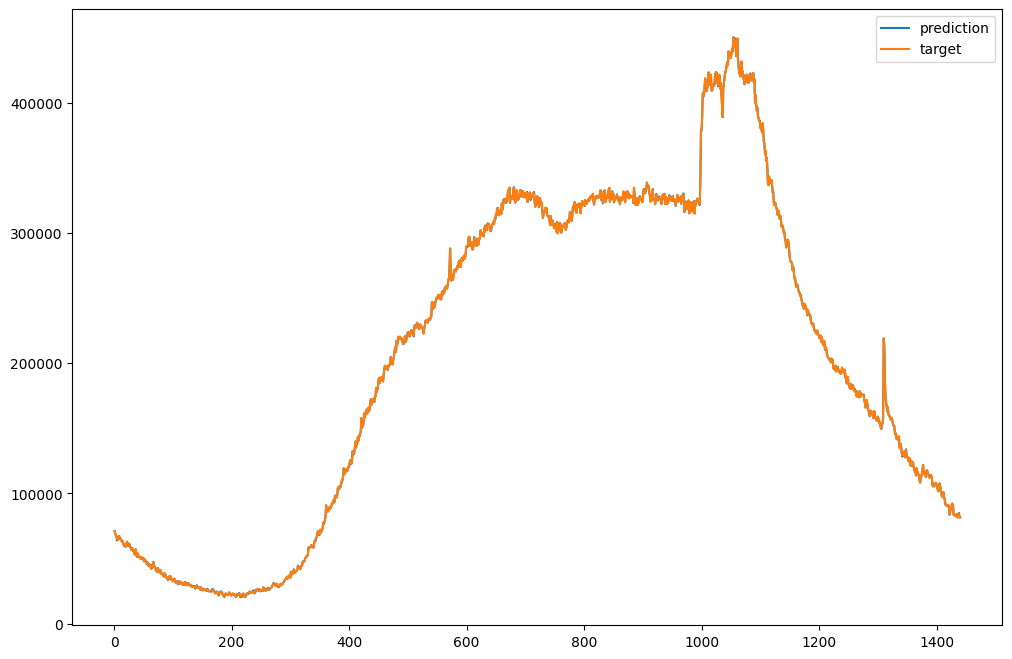

In [51]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,1441),pred_list,label='prediction')
axes.plot(np.arange(1,1441),target,label='target')
axes.legend()

In [53]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.2850661873817444 %


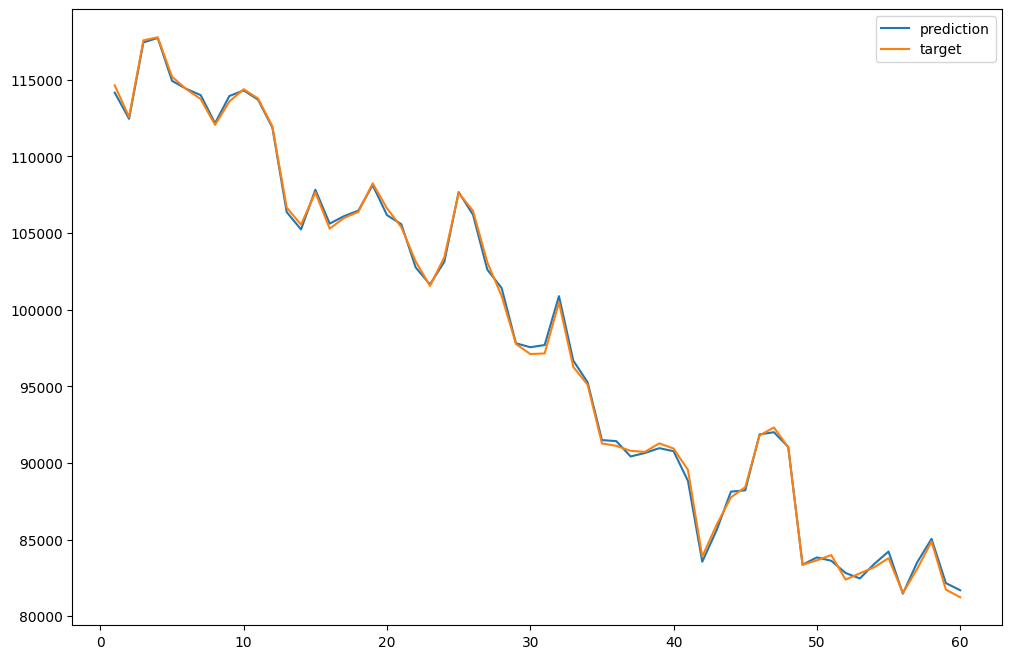

In [54]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

<font color = blue><font size = 6> Conclusion </font></font><br>
훈련을 하지 않았을때는 7퍼센트의 결과를 보였고 이해 비해서 0.28 퍼센트의 결과는 매우 좋은 결과이다 online-learning-DLinear와 비교해봤을때도 더 좋은 성능을 보인다 이것은 1step-DLinear와 1step-NLinear 의 성능 차이와 비슷한 이유일 것이라고 사료된다